Overview
Задача рекомендаций фильмов пользователям на основе истории оценок.
В качестве сабмита необходимо предоставить 10 рекомендуемых фильмов для каждого пользователя (см. submission_sample.csv).

Метрика: recall@10

Для зачета домашнего задания необходимо:

Предоставить командный git репозиторий. В репозитории должна быть указана роль каждого члена команды (отмечен скрипт/часть скрипта каждого члена команды).
Метрики в репозитории должны быть воспроизводимы

**Данные**:
1. events.csv - интеракции пользователей (история оценок)
2. user_features.csv - признаки пользователя
3. item_features.csv - признаки фильмов
4. submission_sample.csv - пример сабмита
5. Формат сабмита: user_id[str], item_id[str] - см submission_sample.csv

In [81]:
!pip install pandas catboost implicit seaborn recbole lightgbm ray pyarrow kmeans_pytorch ipywidgets


# EDA

In [139]:
import warnings
warnings.filterwarnings('ignore')

In [174]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from recbole.utils.case_study import full_sort_topk
# Установка стилей для визуализаций
sns.set_theme(style='whitegrid', palette='muted')
%matplotlib inline


In [34]:
# Загрузка данных из CSV файлов
events = pd.read_csv('data/events.csv')
user_features = pd.read_csv('data/user_features.csv')
item_features = pd.read_csv('data/item_features.csv')


# Events

In [13]:
print("Events DataFrame:")
print(events.head())
print(events.info())
print(events.describe())


Events DataFrame:
   user_id  item_id  rating  timestamp
0        0     1505       4          0
1        0     3669       3          1
2        0      584       4          2
3        0     3390       3          3
4        0     2885       4          4
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 894149 entries, 0 to 894148
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    894149 non-null  int64
 1   item_id    894149 non-null  int64
 2   rating     894149 non-null  int64
 3   timestamp  894149 non-null  int64
dtypes: int64(4)
memory usage: 27.3 MB
None
             user_id        item_id         rating      timestamp
count  894149.000000  894149.000000  894149.000000  894149.000000
mean     3000.009516    1844.262022       3.580947     194.684738
std      1732.316153    1077.520786       1.116696     218.812300
min         0.000000       0.000000       1.000000       0.000000
25%      1512.000000     906.0

# User

In [14]:
print("User Features DataFrame:")
print(user_features.head())
print(user_features.info())
print(user_features.describe())


User Features DataFrame:
   user_id gender  age
0     4855      F    1
1     4065      M   56
2     3331      M   25
3     5373      M   45
4     2032      M   25
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  6040 non-null   int64 
 1   gender   6040 non-null   object
 2   age      6040 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 141.7+ KB
None
           user_id          age
count  6040.000000  6040.000000
mean   3019.500000    30.639238
std    1743.742145    12.895962
min       0.000000     1.000000
25%    1509.750000    25.000000
50%    3019.500000    25.000000
75%    4529.250000    35.000000
max    6039.000000    56.000000


# Item

In [15]:
print("Item Features DataFrame:")
print(item_features.head())
print(item_features.info())
print(item_features.describe())


Item Features DataFrame:
   item_id  genre_0  genre_1  genre_2  genre_3  genre_4  genre_5  genre_6  \
0        0        0        1        0        1        1        0        0   
1        1        0        0        0        0        0        0        0   
2        2        0        0        0        0        0        0        0   
3        3        0        0        0        0        0        0        0   
4        4        0        0        0        0        0        0        0   

   genre_7  genre_8  genre_9  genre_10  genre_11  genre_12  genre_13  \
0        0        1        0         0         0         0         1   
1        1        0        0         0         0         0         0   
2        1        0        0         0         0         0         0   
3        1        0        0         0         0         0         1   
4        1        0        0         0         0         0         0   

   genre_14  genre_15  genre_16  genre_17  
0         0         0         0    

# Rating distribution

Unique ratings: [4 3 5 2 1]


/var/folders/9y/9f_dlksd3zq7q65kpsdpdmg00000gn/T/ipykernel_48053/54101763.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=events, palette='viridis')


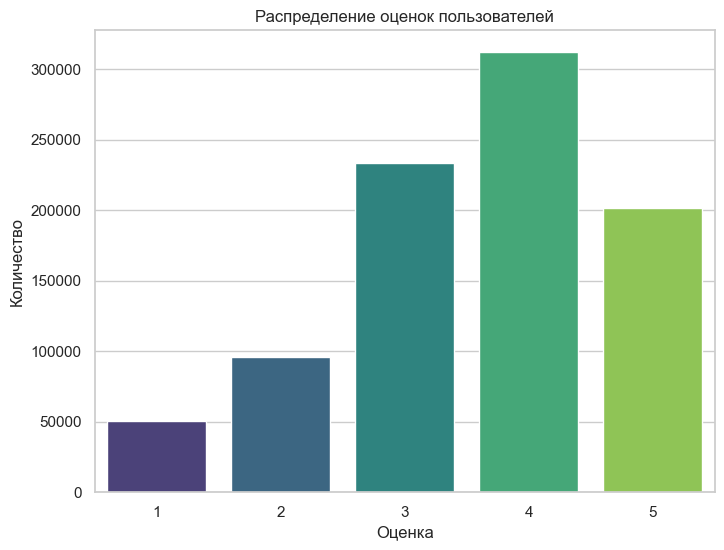

In [19]:
# Проверка уникальных значений в рейтингах
print("Unique ratings:", events['rating'].unique())

# Гистограмма распределения оценок
plt.figure(figsize=(8,6))
sns.countplot(x='rating', data=events, palette='viridis')
plt.title('Распределение оценок пользователей')
plt.xlabel('Оценка')
plt.ylabel('Количество')
plt.show()


In [42]:
events.groupby('rating')['timestamp'].count()

rating
1     50256
2     96001
3    233824
4    312170
5    201898
Name: timestamp, dtype: int64

# Rating-user distribution

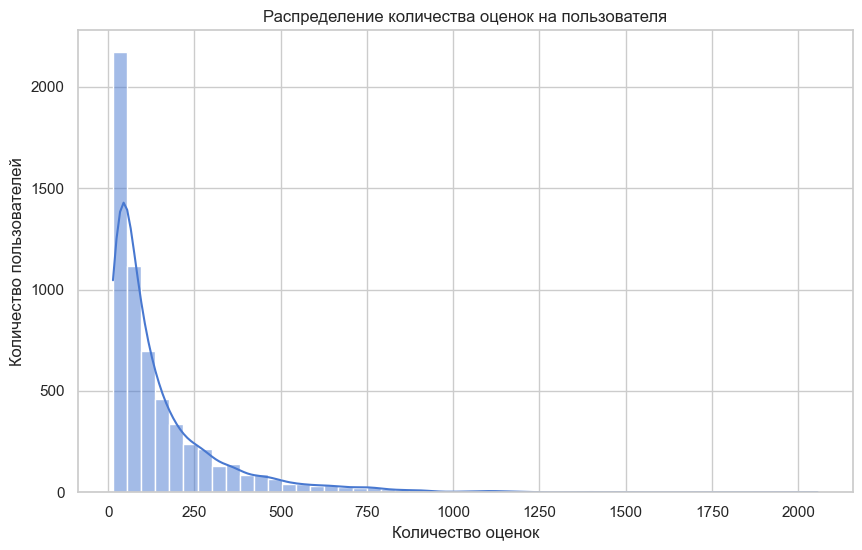

count    6040.000000
mean      148.037914
std       173.461681
min        14.000000
10%        24.000000
20%        33.000000
30%        45.000000
40%        62.000000
50%        84.500000
60%       114.000000
70%       154.000000
80%       227.000000
90%       357.000000
100%     2056.000000
max      2056.000000
Name: num_ratings, dtype: float64


In [44]:
# Подсчет количества оценок каждым пользователем
user_activity = events.groupby('user_id')['rating'].count().reset_index()
user_activity.columns = ['user_id', 'num_ratings']

# Распределение количества оценок на пользователя
plt.figure(figsize=(10,6))
sns.histplot(user_activity['num_ratings'], bins=50, kde=True)
plt.title('Распределение количества оценок на пользователя')
plt.xlabel('Количество оценок')
plt.ylabel('Количество пользователей')
plt.show()

# Статистики по активности пользователей
print(user_activity['num_ratings'].describe([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]))


# Rating-item distribution

Топ-10 самых популярных фильмов:
      item_id  num_ratings
469       472         3067
1574     1583         2699
3009     3022         2639
2285     2297         2612
581       584         2423
3513     3529         2384
635       640         2363
2720     2732         2328
1821     1831         2313
1217     1223         2310


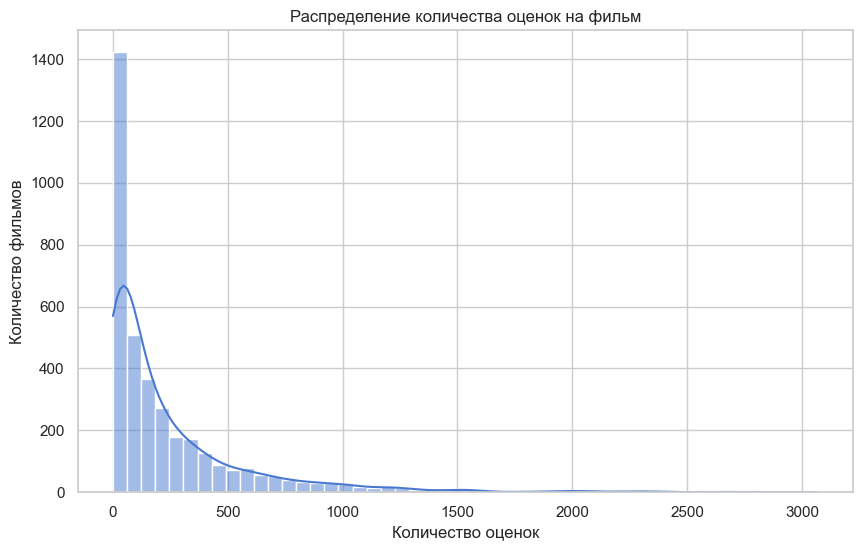

count    3690.000000
mean      242.316802
std       343.984762
min         1.000000
10%         6.000000
20%        21.000000
30%        40.000000
40%        68.000000
50%       111.000000
60%       168.000000
70%       250.000000
80%       384.200000
90%       656.100000
100%     3067.000000
max      3067.000000
Name: num_ratings, dtype: float64


In [45]:
# Подсчет количества оценок для каждого фильма
item_popularity = events.groupby('item_id')['rating'].count().reset_index()
item_popularity.columns = ['item_id', 'num_ratings']

# Топ-10 самых популярных фильмов
top_items = item_popularity.sort_values('num_ratings', ascending=False).head(10)
print("Топ-10 самых популярных фильмов:")
print(top_items)

# Распределение количества оценок на фильм
plt.figure(figsize=(10,6))
sns.histplot(item_popularity['num_ratings'], bins=50, kde=True)
plt.title('Распределение количества оценок на фильм')
plt.xlabel('Количество оценок')
plt.ylabel('Количество фильмов')
plt.show()

# Статистики по популярности фильмов
print(item_popularity['num_ratings'].describe([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]))


# User features

In [22]:
# Разделение признаков на числовые и категориальные
numeric_features = user_features.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = user_features.select_dtypes(exclude=[np.number]).columns.tolist()

print("Числовые признаки пользователей:", numeric_features)
print("Категориальные признаки пользователей:", categorical_features)


Числовые признаки пользователей: ['user_id', 'age']
Категориальные признаки пользователей: ['gender']


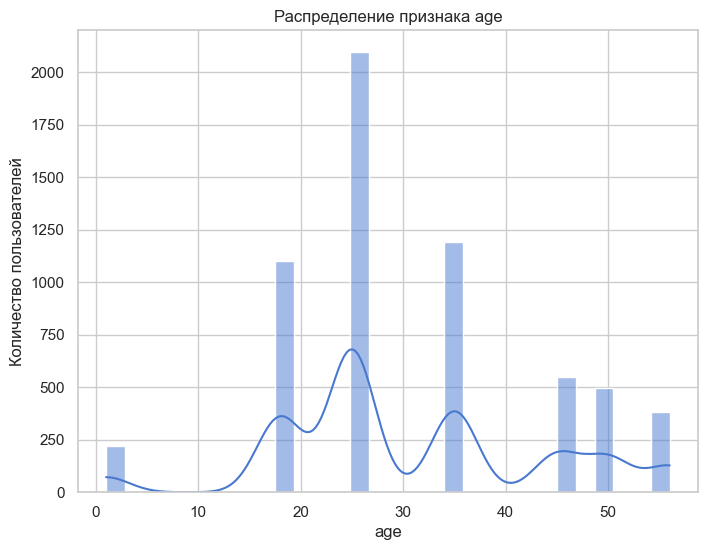

In [24]:
# Распределение числовых признаков
for feature in numeric_features[1:]:
    plt.figure(figsize=(8,6))
    sns.histplot(user_features[feature], bins=30, kde=True)
    plt.title(f'Распределение признака {feature}')
    plt.xlabel(feature)
    plt.ylabel('Количество пользователей')
    plt.show()


In [49]:
user_features['age'].value_counts()

age
25    2096
35    1193
18    1103
45     550
50     496
56     380
1      222
Name: count, dtype: int64

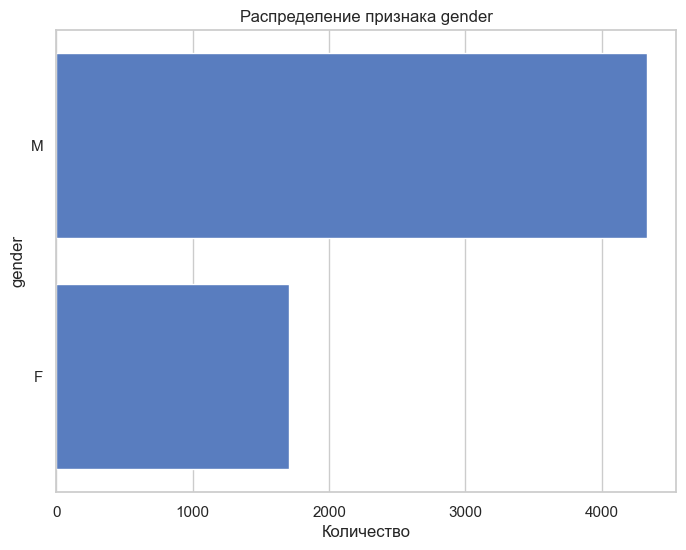

In [25]:
# Распределение категориальных признаков
for feature in categorical_features:
    plt.figure(figsize=(8,6))
    sns.countplot(y=feature, data=user_features, order=user_features[feature].value_counts().index)
    plt.title(f'Распределение признака {feature}')
    plt.xlabel('Количество')
    plt.ylabel(feature)
    plt.show()


In [50]:
user_features['gender'].value_counts()

gender
M    4331
F    1709
Name: count, dtype: int64

# Item features

In [27]:
# Разделение признаков на числовые и категориальные
numeric_features_items = item_features.select_dtypes(include=[np.number]).columns.tolist()
categorical_features_items = item_features.select_dtypes(exclude=[np.number]).columns.tolist()

print("Числовые признаки фильмов:", numeric_features_items)
print("Категориальные признаки фильмов:", categorical_features_items)


Числовые признаки фильмов: ['item_id', 'genre_0', 'genre_1', 'genre_2', 'genre_3', 'genre_4', 'genre_5', 'genre_6', 'genre_7', 'genre_8', 'genre_9', 'genre_10', 'genre_11', 'genre_12', 'genre_13', 'genre_14', 'genre_15', 'genre_16', 'genre_17']
Категориальные признаки фильмов: []


In [57]:
for feature in numeric_features_items[1:]:
    print(item_features[feature].value_counts())

genre_0
0    3211
1     495
Name: count, dtype: int64
genre_1
0    3425
1     281
Name: count, dtype: int64
genre_2
0    3601
1     105
Name: count, dtype: int64
genre_3
0    3456
1     250
Name: count, dtype: int64
genre_4
0    2543
1    1163
Name: count, dtype: int64
genre_5
0    3505
1     201
Name: count, dtype: int64
genre_6
0    3596
1     110
Name: count, dtype: int64
genre_7
0    2213
1    1493
Name: count, dtype: int64
genre_8
0    3638
1      68
Name: count, dtype: int64
genre_9
0    3662
1      44
Name: count, dtype: int64
genre_10
0    3367
1     339
Name: count, dtype: int64
genre_11
0    3593
1     113
Name: count, dtype: int64
genre_12
0    3602
1     104
Name: count, dtype: int64
genre_13
0    3247
1     459
Name: count, dtype: int64
genre_14
0    3432
1     274
Name: count, dtype: int64
genre_15
0    3221
1     485
Name: count, dtype: int64
genre_16
0    3565
1     141
Name: count, dtype: int64
genre_17
0    3639
1      67
Name: count, dtype: int64


# Correlations

In [30]:
events_items = pd.merge(events, item_features, on='item_id', how='left')

corr_matrix = events_items[['rating'] + numeric_features_items].corr()
print("Корреляционная матрица:")
print(corr_matrix['rating'].sort_values(ascending=False))


Корреляционная матрица:
rating      1.000000
genre_7     0.122675
genre_16    0.075753
genre_9     0.060380
genre_5     0.033169
genre_6     0.028262
genre_2     0.019175
genre_12    0.015871
genre_11    0.015266
genre_13    0.009702
item_id     0.008097
genre_17    0.007020
genre_15   -0.004879
genre_8    -0.023505
genre_1    -0.036892
genre_4    -0.040167
genre_3    -0.040481
genre_14   -0.043994
genre_0    -0.047415
genre_10   -0.094018
Name: rating, dtype: float64


In [63]:
for feature in numeric_features_items[1:]:
    print(events_items.groupby(feature)['rating'].mean())

genre_0
0    3.612132
1    3.491048
Name: rating, dtype: float64
genre_1
0    3.597153
1    3.476219
Name: rating, dtype: float64
genre_2
0    3.576389
1    3.681547
Name: rating, dtype: float64
genre_3
0    3.593568
1    3.419043
Name: rating, dtype: float64
genre_4
0    3.614340
1    3.520699
Name: rating, dtype: float64
genre_5
0    3.570042
1    3.706751
Name: rating, dtype: float64
genre_6
0    3.578140
1    3.935852
Name: rating, dtype: float64
genre_7
0    3.479370
1    3.765698
Name: rating, dtype: float64
genre_8
0    3.58603
1    3.44540
Name: rating, dtype: float64
genre_9
0    3.571762
1    4.075945
Name: rating, dtype: float64
genre_10
0    3.611114
1    3.215561
Name: rating, dtype: float64
genre_11
0    3.577396
1    3.662794
Name: rating, dtype: float64
genre_12
0    3.577324
1    3.667642
Name: rating, dtype: float64
genre_13
0    3.576442
1    3.607003
Name: rating, dtype: float64
genre_14
0    3.602171
1    3.467226
Name: rating, dtype: float64
genre_15
0    3.583581

# Timestamp analysis

In [70]:
events.groupby('timestamp')['rating'].count().describe([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98, 1])


count    2256.000000
mean      396.342642
std       922.590881
min         1.000000
10%         1.000000
20%         2.000000
30%         3.000000
40%         6.000000
50%        24.000000
60%        56.000000
70%       173.000000
80%       426.000000
90%      1227.500000
95%      2370.500000
98%      3962.100000
100%     5489.000000
max      5489.000000
Name: rating, dtype: float64

In [40]:
# Создание сводной таблицы (матрицы взаимодействий)
interaction_matrix = events.pivot_table(index='user_id', columns='item_id', values='rating')

# Проверка разреженности матрицы
sparsity = 1.0 - len(events) / float(interaction_matrix.shape[0] * interaction_matrix.shape[1])
print('Разреженность матрицы взаимодействий: {:.2%}'.format(sparsity))


Разреженность матрицы взаимодействий: 95.99%


# Models

In [95]:
import os
import pandas as pd
import numpy as np
import torch
from recbole.config import Config
from recbole.utils import init_seed, init_logger, get_trainer, get_model
from recbole.data import create_dataset, data_preparation
from recbole.trainer import Trainer
import logging
from logging import getLogger


In [96]:
data_path = './data'
events_file = os.path.join(data_path, 'events.csv')
user_features_file = os.path.join(data_path, 'user_features.csv')
item_features_file = os.path.join(data_path, 'item_features.csv')


events = pd.read_csv(events_file)
user_features = pd.read_csv(user_features_file)
item_features = pd.read_csv(item_features_file)


In [97]:
user_features['gender'] = user_features['gender'].map({'M': 0, 'F': 1}).astype(int)
user_features['age'] = user_features['age'].astype(int)
genre_cols = [col for col in item_features.columns if 'genre_' in col]


def get_genre_ids(row):
    return [i for i, col in enumerate(genre_cols) if row[col] == 1]

item_features['genre_ids'] = item_features.apply(get_genre_ids, axis=1)


item_features = item_features[['item_id', 'genre_ids']]

item_features['genre_ids'] = item_features['genre_ids'].apply(lambda x: ' '.join(map(str, x)))

## Inter

In [117]:
recbole_data_path = './recbole_data'
dataset_name = 'movies'
dataset_path = os.path.join(recbole_data_path, dataset_name)
if not os.path.exists(dataset_path):
    os.makedirs(dataset_path)

interactions = events[['user_id', 'item_id', 'rating', 'timestamp']]
inter_file = os.path.join(dataset_path, f'{dataset_name}.inter')
interactions.to_csv(inter_file, sep='\t', index=False)

user_file = os.path.join(dataset_path, f'{dataset_name}.user')
user_features.to_csv(user_file, sep='\t', index=False)

item_file = os.path.join(dataset_path, f'{dataset_name}.item')
item_features.to_csv(item_file, sep='\t', index=False)


## Config

In [ ]:

parameter_dict = {
    'data_path': recbole_data_path,
    'dataset': dataset_name,
    'USER_ID_FIELD': 'user_id',
    'ITEM_ID_FIELD': 'item_id',
    'RATING_FIELD': 'rating',
    'TIME_FIELD': 'timestamp',
    'load_col': {
        'inter': ['user_id', 'item_id', 'rating', 'timestamp'],
        'user': ['user_id', 'gender', 'age'],
        'item': ['item_id', 'genre_ids'],
    },
    'train_neg_sample_args': {
        'distribution': 'uniform',
        'sample_num': 1,
        'dynamic': False,
        'candidate_num': 0,
        'alpha': 1.0,  # Дополнительно для некоторых моделей с негативным семплированием
    },
    'eval_args': {
        'split': {'RS': [0.8, 0.1, 0.1]},
        'group_by': 'user',
        'order': 'TO',
        'mode': {'valid': 'full', 'test': 'full'},  # Задано поэтапно для каждого этапа
    },
    'metrics': ['Recall', 'NDCG', 'Hit', 'Precision', 'MAP'],
    'topk': 10,
    'valid_metric': 'Recall@10',  # Указан для ранней остановки на этапе валидации
    'epochs': 1,
    'stopping_step': 3,
    'seed': 42,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'show_progress': True,
    'checkpoint_dir': './saved',
    'checkpoint_save_steps': 1,  # Частое сохранение контрольной точки для долгих эпох
    'logging_level': 'INFO',
    'worker': 10,
    'reproducibility': True,
    'state': 'INFO',  # Уровень логов для вывода
}

# Train and evaluate

In [204]:
models_single_epoch = [
    'Pop',        # Популярностная модель
    'ItemKNN',    # Модель ближайших соседей по элементам
    'SLIMElastic', # Модель SLIM с эластичным регуляризатором
    'EASE',       # Модель EASE для рекомендаций
]

# Функция тренировки и оценки
def train_and_evaluate(model_name, parameter_dict):
    config_dict = parameter_dict.copy()
    
    # Настройка параметров для моделей без семплирования
    if model_name in models_need_no_neg_sampling:
        config_dict.pop('train_neg_sample_args', None)
    
    # Установка 1 эпохи для моделей из списка
    config_dict['epochs'] = 1 if model_name in models_single_epoch else parameter_dict['epochs']
    
    # Инициализация конфигурации и логгера
    config = Config(model=model_name, config_dict=config_dict)
    init_seed(config['seed'], config['reproducibility'])
    init_logger(config)
    logger = getLogger()
    
    # Загрузка датасета
    dataset = create_dataset(config)
    logger.info(dataset)
    
    # Разделение данных
    train_data, valid_data, test_data = data_preparation(config, dataset)
    
    # Инициализация модели и тренера
    model = get_model(config['model'])(config, train_data.dataset).to(config['device'])
    trainer = get_trainer(config['MODEL_TYPE'], config['model'])(config, model)
    
    # Запуск тренировки
    best_valid_score, best_valid_result = trainer.fit(train_data, valid_data)
    
    # Оценка модели
    test_result = trainer.evaluate(test_data, load_best_model=True)
    

    return model, dataset, config, best_valid_result, test_result

In [206]:
models_need_no_neg_sampling = [
    'MultiVAE', 'MultiDAE', 'MacridVAE', 'RecVAE', 'GRU4Rec', 'NARM', 'STAMP', 
    'NextItNet', 'TransRec', 'SASRec', 'BERT4Rec', 'SRGNN', 'GCSAN', 'GRU4RecF', 
    'FOSSIL', 'SHAN', 'RepeatNet', 'HRM', 'NPE'
]

# Модели для обучения
models_to_train = [
    'Pop', 
    'ItemKNN', 
    'BPR', 
    # 'NeuMF', 
    'LightGCN', 
    # 'NGCF', 
    # 'xDeepFM', 
    'AutoInt', 
    # 'RecVAE'
]

In [207]:
results = []
for model_name in models_to_train:
    print(f'\nTraining {model_name}...')
    model, dataset, config, best_valid_result, test_result = train_and_evaluate(model_name, parameter_dict)
    results.append({'Model': model_name, 'Best Valid Result': best_valid_result, 'Test Result': test_result})

# Сохранение и вывод результатов
results_df = pd.DataFrame(results)
results_df.to_csv('./model_comparison_results.csv', index=False)
print("Final Results:\n", results_df)


Training Pop...


25 Oct 18:24    INFO  movies
The number of users: 6041
Average actions of users: 148.03791390728477
The number of items: 3707
Average actions of items: 242.31680216802167
The number of inters: 894149
The sparsity of the dataset: 96.00719157334512%
Remain Fields: ['user_id', 'item_id', 'rating', 'timestamp', 'gender', 'age', 'genre_ids']
25 Oct 18:24    INFO  [Training]: train_batch_size = [2048] train_neg_sample_args: [{'distribution': 'uniform', 'sample_num': 1, 'dynamic': False, 'candidate_num': 0, 'alpha': 1.0}]
25 Oct 18:24    INFO  [Evaluation]: eval_batch_size = [4096] eval_args: [{'split': {'RS': [0.8, 0.1, 0.1]}, 'order': 'TO', 'group_by': 'user', 'mode': {'valid': 'full', 'test': 'full'}}]
25 Oct 18:24    INFO  epoch 0 training [time: 35.39s, train loss: 0.0000]
25 Oct 18:25    INFO  epoch 0 evaluating [time: 45.89s, valid_score: 0.035400]
25 Oct 18:25    INFO  valid result: 
recall@10 : 0.0354    ndcg@10 : 0.0475    hit@10 : 0.2523    precision@10 : 0.0392    map@10 : 0.0206



Training ItemKNN...


25 Oct 18:26    INFO  movies
The number of users: 6041
Average actions of users: 148.03791390728477
The number of items: 3707
Average actions of items: 242.31680216802167
The number of inters: 894149
The sparsity of the dataset: 96.00719157334512%
Remain Fields: ['user_id', 'item_id', 'rating', 'timestamp', 'gender', 'age', 'genre_ids']
25 Oct 18:26    INFO  [Training]: train_batch_size = [2048] train_neg_sample_args: [{'distribution': 'uniform', 'sample_num': 1, 'dynamic': False, 'candidate_num': 0, 'alpha': 1.0}]
25 Oct 18:26    INFO  [Evaluation]: eval_batch_size = [4096] eval_args: [{'split': {'RS': [0.8, 0.1, 0.1]}, 'order': 'TO', 'group_by': 'user', 'mode': {'valid': 'full', 'test': 'full'}}]
25 Oct 18:26    INFO  epoch 0 training [time: 31.55s, train loss: 0.0000]
25 Oct 18:27    INFO  epoch 0 evaluating [time: 48.69s, valid_score: 0.066900]
25 Oct 18:27    INFO  valid result: 
recall@10 : 0.0669    ndcg@10 : 0.0612    hit@10 : 0.3048    precision@10 : 0.0437    map@10 : 0.0285



Training BPR...


25 Oct 18:28    INFO  movies
The number of users: 6041
Average actions of users: 148.03791390728477
The number of items: 3707
Average actions of items: 242.31680216802167
The number of inters: 894149
The sparsity of the dataset: 96.00719157334512%
Remain Fields: ['user_id', 'item_id', 'rating', 'timestamp', 'gender', 'age', 'genre_ids']
25 Oct 18:28    INFO  [Training]: train_batch_size = [2048] train_neg_sample_args: [{'distribution': 'uniform', 'sample_num': 1, 'dynamic': False, 'candidate_num': 0, 'alpha': 1.0}]
25 Oct 18:28    INFO  [Evaluation]: eval_batch_size = [4096] eval_args: [{'split': {'RS': [0.8, 0.1, 0.1]}, 'order': 'TO', 'group_by': 'user', 'mode': {'valid': 'full', 'test': 'full'}}]
25 Oct 18:29    INFO  epoch 0 training [time: 34.39s, train loss: 213.4300]
25 Oct 18:30    INFO  epoch 0 evaluating [time: 49.30s, valid_score: 0.037500]
25 Oct 18:30    INFO  valid result: 
recall@10 : 0.0375    ndcg@10 : 0.0492    hit@10 : 0.2624    precision@10 : 0.0413    map@10 : 0.021

In [179]:
results_df

NameError: name 'results_df' is not defined